In [625]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import datetime as dt
from statistics import stdev
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from IPython.display import clear_output
import numpy as np

In [505]:
def read_files():
    train =[]
    test =[]
    RUL =[]
    for i in range(0,4):
        train.append(pd.read_csv('train_FD00'+str(i+1)+'.txt', delimiter=" ", decimal=".", header=None))
        test.append(pd.read_csv('test_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
        RUL.append(pd.read_csv('RUL_FD00'+str(i+1)+'.txt',  delimiter=" ", decimal=".", header=None))
    return(train, test, RUL)

In [506]:
def remove_mssng_df(dfs, cols):
    cln= []
    for df in dfs:
        df.drop(df.columns[list(df.columns[df.isnull().sum() > 0])], axis=1, inplace=True)
        df.columns = cols
        cln.append(df)
    return(cln)

In [507]:
def remove_low_variance(train, test, threshold = 0.10):
    tr=[]
    te=[]
    var_lsts =[]
    for df1, df2 in zip(train, test):
        var_lst= list(df1.columns[df1.var()> threshold])
        d1= df1.loc[:,var_lst]
        d2= df2.loc[:,var_lst]
        tr.append(d1)
        te.append(d2)
        var_lsts.append(var_lst)
    return(tr, te, var_lsts)

In [508]:
def add_RULS(dfs):
    df1=[]
    for df in dfs:
        df = pd.merge(df, df.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
        df.rename(columns={"cycles_x": "cycles", "cycles_y": "maxcycles"}, inplace=True)
        df['RUL'] = df['maxcycles'] - df['cycles']
        df1.append(df)
    return(df1)

In [487]:
def prep_model_data(trains, tests, RULs, var_lsts, exclude, target='RUL'):
    data_sets={}
    i=0
    for var_list,train,test,RUL in zip(var_lsts,trains,tests,RULs):
        features = list(set(var_list).difference(set(exclude)))
        train= train.loc[~(train.cycles == train.maxcycles)]
        y= train.loc[:,target].values
        yscaler = MinMaxScaler()
        yscaler.fit(y.reshape(-1, 1))
        y= yscaler.transform(y.reshape(-1, 1))
        RUL = yscaler.transform(RUL.values)
        train_x= train.loc[:,features].values
        test_unt = test.loc[:,['unit']].values
        test_x= test.loc[:,features].values
        scaler = MinMaxScaler()
        scaler.fit(train_x)
        train_X= scaler.transform(train_x)
        test_X= scaler.transform(test_x)
        data_sets[i]=[train_X,y,test_X,RUL,yscaler,test_unt]
        i +=1
    return(data_sets)

In [509]:
def create_mlp(dim):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return(model)

In [613]:
def fit_mlp(trainX, trainY,EPCH= 200, qual_metric= 'mean_squared_error'):
    dim = trainX.shape[1]
    model = create_mlp(dim)
    opt = keras.optimizers.Adam(learning_rate=0.005)
    model.compile(loss=qual_metric, optimizer=opt)
    # train the model
    print("[INFO] training model...")
    model.fit(x=trainX, y=trainY, epochs=EPCH, batch_size=8)
    return(model)

In [607]:
def score_mlp(model, testX, yscaler, RUL, test_unit):
    ypred= model.predict(testX)
    p_RUL = yscaler.inverse_transform(ypred)
    df = pd.DataFrame(np.concatenate([test_unit, p_RUL], axis=1), columns= ['unit','pRUL'])
    p_RUL= df.groupby('unit')['pRUL'].agg(['min']).values
    qual_metric= mean_squared_error(RUL, p_RUL)
    return(p_RUL, qual_metric)

In [608]:
def fit_score_mlp(model_sets, EPCH=20):
    fitted_models = {}
    i=0
    for k, v in model_sets.items():
        print('Building & Scoring Set # :',k+1)
        trainX= v[0]
        trainY= v[1]
        testX= v[2]
        testY= v[3]
        yscaler= v[4]
        test_unit = v[5]
        model= fit_mlp(trainX, trainY, EPCH)
        p_RUL, qual_metric= score_mlp(model, testX, yscaler, testY, test_unit)
        fitted_models[i]=[model,yscaler,p_RUL, qual_metric]
        clear_output(wait=True)
        i+=1
    return(fitted_models)

# Main

In [609]:
cols = ['unit', 'cycles', 'op_setting1', 'op_setting2', 'op_setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [531]:
exclude = ['unit', 'maxcycles', 'RUL']

In [614]:
trains, tests, RULs= read_files()
trains = remove_mssng_df(trains, cols)
RULs = remove_mssng_df(RULs, ['rul'])
tests = remove_mssng_df(tests, cols)
trains, tests, var_lsts = remove_low_variance(trains, tests, 0.01)
trains = add_RULS(trains)

In [615]:
model_sets = prep_model_data(trains, tests, RULs, var_lsts, exclude, 'RUL')

In [616]:
fitted_models = fit_score_mlp(model_sets, 35)

Building & Scoring Set # : 4
[INFO] training model...
Epoch 1/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0277
Epoch 2/35
7625/7625 [==============================] - 5s 623us/step - loss: 0.0276
Epoch 3/35
7625/7625 [==============================] - 5s 623us/step - loss: 0.0275
Epoch 4/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0275
Epoch 5/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0275
Epoch 6/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0275
Epoch 7/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0275
Epoch 8/35
7625/7625 [==============================] - 5s 621us/step - loss: 0.0276
Epoch 9/35
7625/7625 [==============================] - 5s 622us/step - loss: 0.0275
Epoch 10/35
7625/7625 [==============================] - 5s 623us/step - loss: 0.0275
Epoch 11/35
7625/7625 [==============================] - 5s 623us/step - loss: 0.0275
Epoch 12/

In [622]:
pRUL=[]
mses1=[]
for k,v in fitted_models.items():
    pRUL.append(v[2])
    mses1.append(v[3])

In [624]:
print(np.sqrt(mses1))

[101.42047053  92.60700824  93.62618837 127.04271571]


In [634]:
df = pd.DataFrame(np.concatenate([pRUL[0], RULs[0]], axis=1), columns= ['Predicted','Actual'])

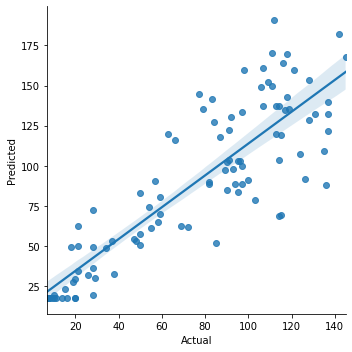

In [635]:
sns.lmplot(x='Actual', y= 'Predicted', data=df)

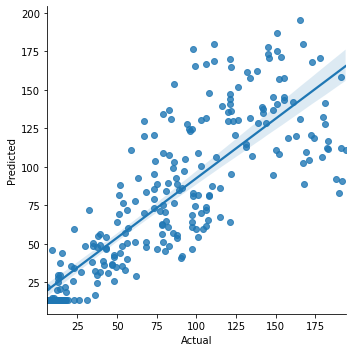

In [636]:
df = pd.DataFrame(np.concatenate([pRUL[1], RULs[1]], axis=1), columns= ['Predicted','Actual'])
sns.lmplot(x='Actual', y= 'Predicted', data=df)

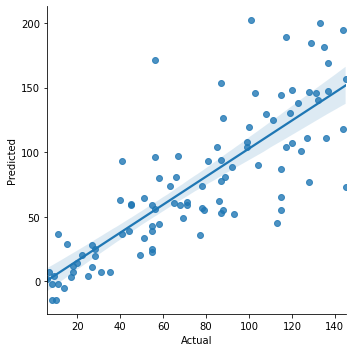

In [637]:
df = pd.DataFrame(np.concatenate([pRUL[2], RULs[2]], axis=1), columns= ['Predicted','Actual'])
sns.lmplot(x='Actual', y= 'Predicted', data=df)

# TSA seasonal decomposition 

In [618]:
var= var_lsts[0]
train = trains[2]
val = train.loc[train.unit==60,var]
# result = seasonal_decompose(val, model='additive')

In [226]:
df= pd.DataFrame(index= [dt.datetime(2019,1,1)+pd.Timedelta(t, unit='S') for t in range(len(val))], data = val.values, columns= ['ts'])
df.index.names = ['Date']

In [349]:
train.loc[~(train.cycles == train.maxcycles)]

,unit,cycles,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s17,s20,s21,maxcycles,RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,47.30,522.31,2388.01,8145.32,391,39.11,23.3537,259,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,47.23,522.42,2388.03,8152.85,392,38.99,23.4491,259,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,47.22,522.03,2388.00,8150.17,391,38.85,23.3669,259,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,47.24,522.49,2388.08,8146.56,392,38.96,23.2951,259,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,47.15,522.58,2388.03,8147.80,392,39.14,23.4583,259,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24714,100,147,643.62,1601.51,1424.82,551.62,2388.27,9057.21,48.11,519.82,2388.24,8139.61,395,38.59,23.0528,152,5
24715,100,148,643.78,1596.01,1424.11,551.86,2388.25,9070.82,48.27,519.66,2388.30,8138.08,394,38.44,22.9631,152,4
24716,100,149,643.29,1596.38,1429.14,551.86,2388.23,9064.60,48.13,519.91,2388.28,8144.36,395,38.50,22.9746,152,3
24717,100,150,643.84,1604.53,1431.41,551.30,2388.25,9063.45,48.18,519.44,2388.24,8135.95,396,38.39,23.0682,152,2


In [267]:
val.apply(lambda x: seasonal_decompose(x, model='additive', period= 5).trend)

,unit,cycles,s2,s3,s4,s7,s9,s11,s12,s14,s17,s20,s21
15263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15265,60.0,3.0,641.590,1581.946,1393.618,553.964,9043.262,47.016,521.058,8133.980,390.8,39.096,23.42400
15266,60.0,4.0,641.780,1582.752,1394.180,553.944,9045.812,47.060,521.040,8134.856,390.4,39.082,23.41296
15267,60.0,5.0,641.982,1583.488,1394.374,553.670,9046.258,47.086,521.250,8135.932,390.4,39.076,23.41528
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448,60.0,186.0,643.290,1603.550,1425.624,567.334,9112.848,48.088,534.830,8187.502,396.0,39.476,23.72318
15449,60.0,187.0,643.278,1602.462,1426.972,567.622,9114.966,48.084,535.196,8188.238,396.0,39.510,23.74384
15450,60.0,188.0,643.396,1601.664,1428.084,568.262,9117.666,48.064,535.664,8189.772,396.2,39.558,23.77534
15451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [254]:
result = seasonal_decompose(df['ts'], model='additive', period= int(len(df)/))
# result.plot()

In [255]:
result.trend

Date
2019-01-01 00:00:00    8129.32
2019-01-01 00:00:01    8130.84
2019-01-01 00:00:02    8138.21
2019-01-01 00:00:03    8136.04
2019-01-01 00:00:04    8135.49
                        ...   
2019-01-01 00:03:05    8187.84
2019-01-01 00:03:06    8185.36
2019-01-01 00:03:07    8193.13
2019-01-01 00:03:08    8189.47
2019-01-01 00:03:09    8193.06
Name: trend, Length: 190, dtype: float64

In [269]:
val.rolling(5).mean()

,unit,cycles,s2,s3,s4,s7,s9,s11,s12,s14,s17,s20,s21
15263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15267,60.0,3.0,641.590,1581.946,1393.618,553.964,9043.262,47.016,521.058,8133.980,390.8,39.096,23.42400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15448,60.0,184.0,642.944,1601.616,1422.786,566.522,9114.486,47.968,534.102,8184.000,395.4,39.574,23.67508
15449,60.0,185.0,643.056,1602.648,1426.602,566.646,9113.934,48.026,534.282,8184.928,395.6,39.500,23.71344
15450,60.0,186.0,643.290,1603.550,1425.624,567.334,9112.848,48.088,534.830,8187.502,396.0,39.476,23.72318
15451,60.0,187.0,643.278,1602.462,1426.972,567.622,9114.966,48.084,535.196,8188.238,396.0,39.510,23.74384


In [472]:
train.loc[:,['unit']].values

array([[  1],
       [  1],
       [  1],
       ...,
       [100],
       [100],
       [100]], dtype=int64)

In [527]:
for i in range(10):
    print("Hello World!")
    clear_output(wait=True)

Hello World!
